# Disease Prevalences

### Imports

In [35]:
import numpy as np
import gmpy2
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

gmpy2.get_context().precision = 113

# Setting the color palette for the plots
sns.set_theme(style='whitegrid', palette="pastel")

### Importing Quickscore

In [2]:
import importlib
from quickscore import fun_quickscoreW2_gmpy2

### Importing metric function

In [3]:
import metrics
importlib.reload(metrics)
from metrics import compute_metrics

## Fixed Values

In [4]:
# For reproducibility
np.random.seed(42)  

# Parameters

# Number of diseases
n_disease = 30

# Number of tests
n_test = 50

# Typical number of diagnoses, should be smaller than n_deases/2
expected_number_of_diseases = 4

# Connection density
sparseness = 0.3
connections = np.random.rand(n_test, n_disease) < sparseness  # Selection of connection

# Sensitivity
sensitivity = 0.4

# Sensitivity Matrix
sensorig = np.full((n_test, n_disease), sensitivity) * connections

# Part 1: Different Prevalence Distributions

## Baseline = uniform prior
- every disease has the same prior

In [5]:
prev = np.full(n_disease, expected_number_of_diseases/n_disease)

print(prev)

[0.13333333 0.13333333 0.13333333 0.13333333 0.13333333 0.13333333
 0.13333333 0.13333333 0.13333333 0.13333333 0.13333333 0.13333333
 0.13333333 0.13333333 0.13333333 0.13333333 0.13333333 0.13333333
 0.13333333 0.13333333 0.13333333 0.13333333 0.13333333 0.13333333
 0.13333333 0.13333333 0.13333333 0.13333333 0.13333333 0.13333333]


In [6]:
# Number of trials
n_trials = 50

# Metrics
baseline_precisions = np.empty(n_trials)
baseline_recalls = np.empty(n_trials)
baseline_f1s = np.empty(n_trials)
baseline_losses = np.empty(n_trials)

for n in range(n_trials):
    print(n)
    flag = 1
    while flag:
        actualdiags = np.where(np.random.rand(n_disease) < prev)[0]  # Generate diseases
        ndiags = len(actualdiags)

        testresults = np.any(np.random.rand(n_test, ndiags) < sensorig[:, actualdiags], axis=1)  # Generate test results

        postest = np.where(testresults == 1)[0]
        negtest = np.where(testresults == 0)[0]
        m = len(postest)

        # ndiags kept constant
        if ndiags == 3 and 10 < m < 15:
            flag = 0  # Exit loop if conditions met
#             print(f"trial: {ndiags:3.0f}, {m:3.0f} OK")
#         else:
#             print(f"trial: {ndiags:3.0f}, {m:3.0f} try again")

    # Prepare data for Quickscore algorithm
    sens = sensorig[postest, :]
    sensneg = sensorig[negtest, :]
    pfmin = 1 - sens
    pfminneg = np.prod(1 - sensneg, axis=0)

    # Quickscore calculation
    posteriorg, _, _ = fun_quickscoreW2_gmpy2(prev, pfmin, pfminneg)

    actualdiseases = np.zeros_like(prev)
    actualdiseases[actualdiags] = 1

    # Metric Calculation

    metrics = compute_metrics(actualdiseases, posteriorg)

    baseline_precisions[n] = metrics["precision"]
    baseline_recalls[n] = metrics["recall"]
    baseline_f1s[n] = metrics["f1_score"]
    baseline_losses[n] = (metrics["log_loss"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [7]:
# Average metric and std
baseline_precision_mean = np.mean(baseline_precisions)
baseline_precision_std = np.std(baseline_precisions)

baseline_recall_mean = np.mean(baseline_recalls)
baseline_recall_std = np.std(baseline_recalls)

baseline_f1s = np.nan_to_num(baseline_f1s, nan=0.0)
baseline_f1_mean = np.mean(baseline_f1s)
baseline_f1_std = np.std(baseline_f1s)

baseline_loss_mean = np.mean(baseline_losses)
baseline_loss_std = np.std(baseline_losses)

## Uniform Distribution
- prevalences with values between 0 and 1

In [8]:
# Shows how they are calculated
prev1 = np.random.rand(n_disease)
prev = expected_number_of_diseases * prev1 / sum(prev1) # rescales prev1 so that the sum of all prevalences equals expected_number_of_diseases

print(prev)

[0.04655088 0.09946331 0.13722246 0.2039158  0.15079808 0.24521357
 0.15736853 0.13957488 0.17239243 0.09014346 0.19298065 0.06789799
 0.15412491 0.04864436 0.04588813 0.20827784 0.08467506 0.25755861
 0.20902406 0.09075059 0.06104473 0.08953026 0.21102802 0.07272707
 0.18067971 0.13738584 0.25273602 0.04800888 0.14172501 0.00266887]


In [9]:
# Number of times the new prev is sampled
n_samples = 10

# Number of trials
n_trials = 5

# Metric per trial
precision_per_trial = np.empty(n_trials)
recall_per_trial = np.empty(n_trials) 
f1_score_per_trial = np.empty(n_trials)
loss_per_trial = np.empty(n_trials)

# Average metric across trials
uniform_precisions = np.empty(n_samples)
uniform_recalls = np.empty(n_samples)
uniform_f1s = np.empty(n_samples)
uniform_losses = np.empty(n_samples)

for i in range(n_samples):

    # Generating prevalences
    prev1 = np.random.rand(n_disease)
    prev = expected_number_of_diseases * prev1 / sum(prev1)

    for j in range(n_trials):
        flag = 1
        while flag:
            actualdiags = np.where(np.random.rand(n_disease) < prev)[0]  # Generate diseases
            ndiags = len(actualdiags)

            testresults = np.any(np.random.rand(n_test, ndiags) < sensorig[:, actualdiags], axis=1)  # Generate test results

            postest = np.where(testresults == 1)[0]
            negtest = np.where(testresults == 0)[0]
            m = len(postest)

            # ndiags kept constant
            if ndiags == 3 and 10 < m < 15:
                flag = 0  # Exit loop if conditions met
#                 print(f"trial: {ndiags:3.0f}, {m:3.0f} OK")
    #         else:
    #             print(f"trial: {ndiags:3.0f}, {m:3.0f} try again")

        # Prepare data for Quickscore algorithm
        sens = sensorig[postest, :]
        sensneg = sensorig[negtest, :]
        pfmin = 1 - sens
        pfminneg = np.prod(1 - sensneg, axis=0)

        # Quickscore calculation
        posteriorg, _, _ = fun_quickscoreW2_gmpy2(prev, pfmin, pfminneg)

        actualdiseases = np.zeros_like(prev)
        actualdiseases[actualdiags] = 1

        metrics = compute_metrics(actualdiseases, posteriorg)

        precision_per_trial[j] = metrics["precision"]
        recall_per_trial[j] = metrics["recall"]
        f1_score_per_trial[j] = metrics["f1_score"]
        loss_per_trial[j] = metrics["log_loss"]
 
    # Mean per sample
    uniform_precisions[i] = np.mean(precision_per_trial)
    uniform_recalls[i] = np.mean(recall_per_trial)
    uniform_f1s[i] = np.mean(f1_score_per_trial)
    uniform_losses[i]= np.mean(loss_per_trial)


In [10]:
# Average metric and std
uniform_precision_mean = np.mean(uniform_precisions)
uniform_precision_std = np.std(uniform_precisions)

uniform_recall_mean = np.mean(uniform_recalls)
uniform_recall_std = np.std(uniform_recalls)


uniform_f1_mean = np.mean(uniform_f1s)
uniform_f1_std = np.std(uniform_f1s)

uniform_loss_mean = np.mean(uniform_losses)
uniform_loss_std = np.std(uniform_losses)

print(uniform_precisions)
print(uniform_recalls)
print(uniform_f1s)

[0.93333333 0.9        0.9        0.86666667 0.8        0.7
 0.8        0.9        0.9        1.        ]
[0.73333333 0.66666667 0.6        0.8        0.73333333 0.46666667
 0.53333333 0.6        0.8        0.66666667]
[0.81333333 0.76       0.7        0.82666667 0.76       0.56
 0.64       0.72       0.84       0.8       ]


## Beta Distribution

- modelling large number of rare diseases but a small number of common diseases => realistic situation

In [11]:
prev1 = np.random.beta(a=0.5, b=5, size=n_disease)
prev = expected_number_of_diseases * prev1 / np.sum(prev1)

print(prev)

[7.84286021e-02 2.50572861e-01 1.47086974e-01 8.68108879e-03
 1.02807416e-05 3.96638922e-02 2.13470663e-01 2.69219618e-02
 1.51570593e-01 2.14416145e-03 2.01658694e-01 1.10925154e-04
 8.67314232e-02 2.48364054e-01 5.52598838e-02 3.77508837e-01
 2.10226193e-03 1.47414120e-02 2.37507984e-03 1.38732198e+00
 1.91943953e-01 2.07953652e-01 3.69640944e-02 3.12982511e-02
 6.85397266e-02 9.80307147e-02 1.25578846e-03 2.08538117e-02
 7.83314291e-03 4.06012399e-02]


Text(0, 0.5, 'Density')

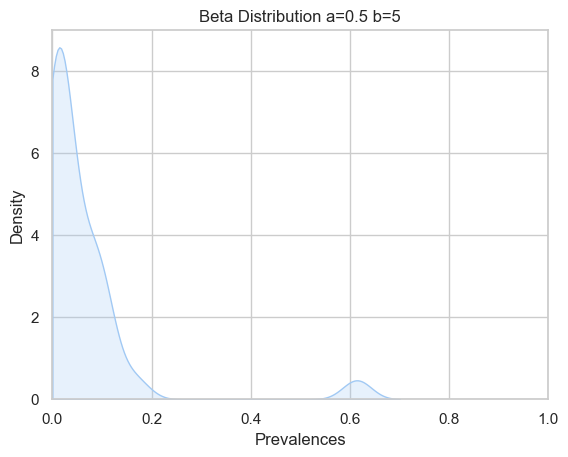

In [12]:
# Plot the distribution that shows this

plt.figure()
sns.kdeplot(prev1, bw_adjust=0.5, fill=True, clip=(0, 1))
plt.xlim(0, 1)
plt.title("Beta Distribution a=0.5 b=5")
plt.xlabel("Prevalences")
plt.ylabel("Density")


In [13]:
# Number of times the new prev is sampled
n_samples = 10

# Number of trials
n_trials = 5

# Metric per trial
precision_per_trial = np.empty(n_trials)
recall_per_trial = np.empty(n_trials) 
f1_score_per_trial = np.empty(n_trials)
loss_per_trial = np.empty(n_trials)

# Average metric across trials
beta_precisions = np.empty(n_samples)
beta_recalls = np.empty(n_samples)
beta_f1s = np.empty(n_samples)
beta_losses = np.empty(n_samples)

for i in range(n_samples):

    # Generating prevalences
    prev1 = np.random.beta(a=0.5, b=5, size=n_disease)
    prev = expected_number_of_diseases * prev1 / np.sum(prev1)

    for j in range(n_trials):
        flag = 1
        while flag:
            actualdiags = np.where(np.random.rand(n_disease) < prev)[0]  # Generate diseases
            ndiags = len(actualdiags)

            testresults = np.any(np.random.rand(n_test, ndiags) < sensorig[:, actualdiags], axis=1)  # Generate test results

            postest = np.where(testresults == 1)[0]
            negtest = np.where(testresults == 0)[0]
            m = len(postest)

            # ndiags kept constant
            if ndiags == 3 and 10 < m < 15:
                flag = 0  # Exit loop if conditions met
#                 print(f"trial: {ndiags:3.0f}, {m:3.0f} OK")
    #         else:
    #             print(f"trial: {ndiags:3.0f}, {m:3.0f} try again")

        # Prepare data for Quickscore algorithm
        sens = sensorig[postest, :]
        sensneg = sensorig[negtest, :]
        pfmin = 1 - sens
        pfminneg = np.prod(1 - sensneg, axis=0)

        # Quickscore calculation
        posteriorg, _, _ = fun_quickscoreW2_gmpy2(prev, pfmin, pfminneg)

        actualdiseases = np.zeros_like(prev)
        actualdiseases[actualdiags] = 1

        # Metric Calculation

        metrics = compute_metrics(actualdiseases, posteriorg)

        precision_per_trial[j] = metrics["precision"]
        recall_per_trial[j] = metrics["recall"]
        f1_score_per_trial[j] = metrics["f1_score"]
        loss_per_trial[j] = metrics["log_loss"]

    beta_precisions[i] = np.mean(precision_per_trial)
    beta_recalls[i]= np.mean(recall_per_trial)
    beta_f1s[i] = np.mean(f1_score_per_trial)
    beta_losses[i] = np.mean(loss_per_trial)


In [15]:
# Average metric and std

beta_precision_mean = np.mean(beta_precisions)
beta_precision_std = np.std(beta_precisions)

beta_recall_mean = np.mean(beta_recalls)
beta_recall_std = np.std(beta_recalls)

beta_f1_mean = np.mean(beta_f1s)
beta_f1_std = np.std(beta_f1s)

beta_loss_mean = np.mean(beta_losses)
beta_loss_std = np.std(beta_losses)

print(beta_precisions)
print(beta_recalls)
print(beta_f1s)

[0.93333333 1.         0.86666667 0.93333333 1.         0.93333333
 0.7        0.9        1.         0.9       ]
[0.73333333 0.8        0.8        0.66666667 0.73333333 0.8
 0.66666667 0.73333333 0.8        0.73333333]
[0.81333333 0.88       0.82666667 0.75333333 0.82       0.85333333
 0.68       0.8        0.88       0.8       ]


## Comparison of Different Distributions

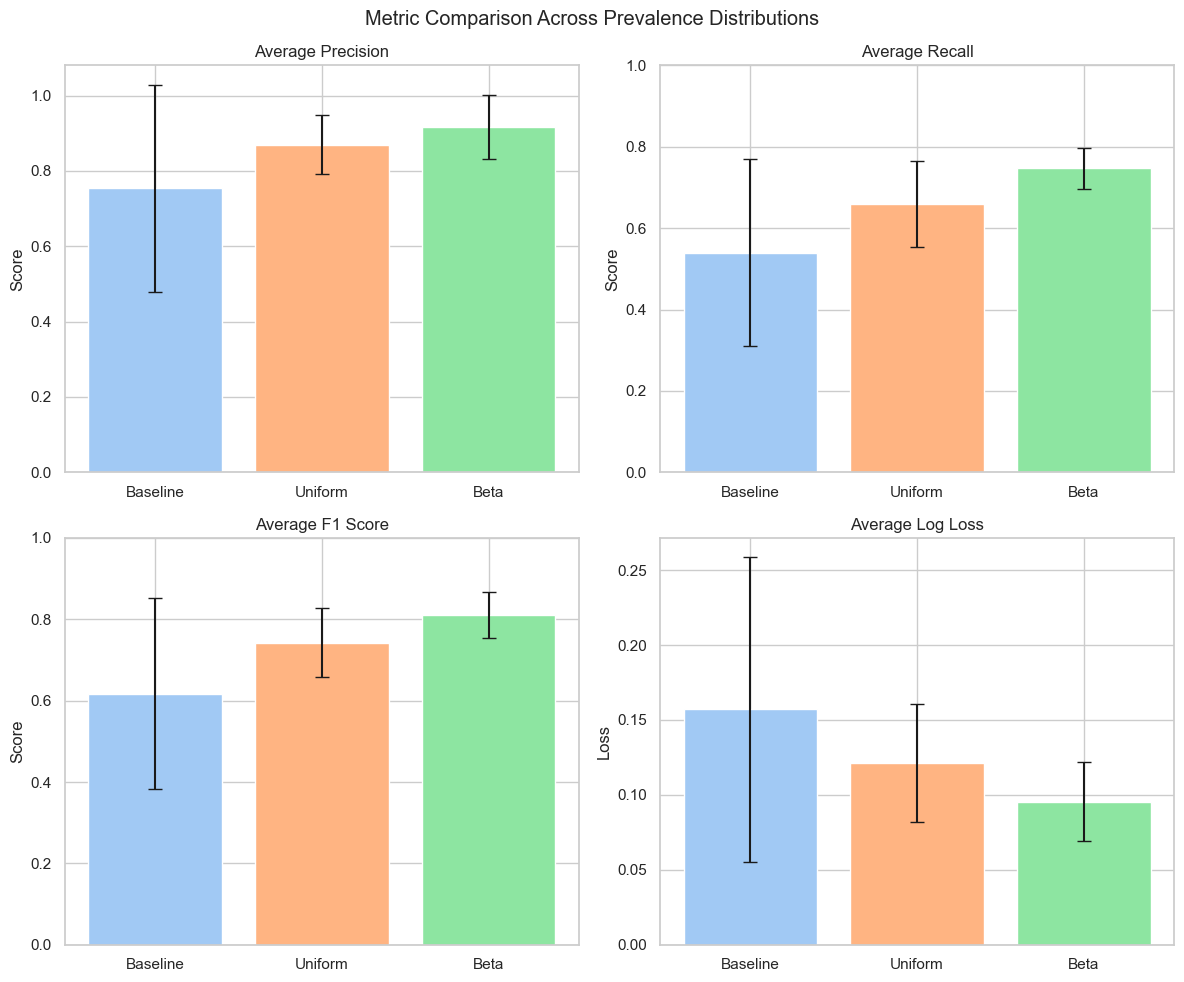

In [22]:
precision_means = [baseline_precision_mean, uniform_precision_mean, beta_precision_mean]
recall_means = [baseline_recall_mean, uniform_recall_mean, beta_recall_mean]
f1_means = [baseline_f1_mean, uniform_f1_mean, beta_f1_mean]
loss_means = [baseline_loss_mean, uniform_loss_mean, beta_loss_mean]


precision_stds = [baseline_precision_std, uniform_precision_std, beta_precision_std]
recall_stds = [baseline_recall_std, uniform_recall_std, beta_recall_std]
f1_stds = [baseline_f1_std, uniform_f1_std, beta_f1_std]
loss_stds = [baseline_loss_std, uniform_loss_std, beta_loss_std]

models = ["Baseline", "Uniform", "Beta"]

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Metric Comparison Across Prevalence Distributions")


colors = sns.color_palette("pastel", 3)

# Precision
axs[0,0].bar(models, precision_means, yerr=precision_stds, capsize=5, color=colors)
axs[0,0].set_title("Average Precision")
axs[0,0].set_ylabel("Score")

# Recall
axs[0,1].bar(models, recall_means, yerr=recall_stds, capsize=5, color=colors)
axs[0,1].set_title("Average Recall")
axs[0,1].set_ylabel("Score")
axs[0,1].set_ylim(0,1)

# F1-score
axs[1,0].bar(models, f1_means, yerr=f1_stds, capsize=5, color=colors)
axs[1,0].set_title("Average F1 Score")
axs[1,0].set_ylabel("Score")
axs[1,0].set_ylim(0,1)

# Loss
axs[1,1].bar(models, loss_means, yerr=loss_stds, capsize=5, color=colors)
axs[1,1].set_title("Average Log Loss")
axs[1,1].set_ylabel("Loss")

plt.tight_layout()
plt.savefig("sp1-A.pdf", dpi=300, bbox_inches='tight')

## Comparing Common and Rare Diseases

In [44]:
# Scaling Down
n_disease = 30
n_test = 30
expected_number_of_diseases = 4
connections = np.random.rand(n_test, n_disease) < sparseness
sensorig = np.full((n_test, n_disease), sensitivity) * connections

n_samples = 10
n_trials = 10

In [45]:

precisions_rare = []
recalls_rare = []
f1s_rare = []
loglosses_rare = []

precisions_common = []
recalls_common = []
f1s_common = []
loglosses_common = []


for j in range(n_samples):
    print(j)

    # Generating prevalences
    prev1 = np.random.beta(a=0.5, b=5, size=n_disease)
    prev = expected_number_of_diseases * prev1 / np.sum(prev1)
    
    # Defining rare and common diseases
    rare = np.where(prev < 0.1)[0]
    common = np.where(prev >= 0.2)[0]

    for n in range(n_trials):
        flag = 1
        while flag:
            actualdiags = np.where(np.random.rand(n_disease) < prev)[0]  # Generate diseases
            ndiags = len(actualdiags)

            testresults = np.any(np.random.rand(n_test, ndiags) < sensorig[:, actualdiags], axis=1)  # Generate test results

            postest = np.where(testresults == 1)[0]
            negtest = np.where(testresults == 0)[0]
            m = len(postest)

            # ndiags kept constant
            if ndiags==3 and 6<m<9 and np.any(np.isin(actualdiags, rare)):
                flag = 0  # Exit loop if conditions met
#                 print(f"trial: {ndiags:3.0f}, {m:3.0f} OK")
    #         else:
    #             print(f"trial: {ndiags:3.0f}, {m:3.0f} try again")

        # Prepare data for Quickscore algorithm
        sens = sensorig[postest, :]
        sensneg = sensorig[negtest, :]
        pfmin = 1 - sens
        pfminneg = np.prod(1 - sensneg, axis=0)

        # Quickscore calculation
        posteriorg, _, _ = fun_quickscoreW2_gmpy2(prev, pfmin, pfminneg)

        actualdiseases = np.zeros_like(prev)
        actualdiseases[actualdiags] = 1

        # Metric Calculation

        metrics_rare = compute_metrics(actualdiseases[rare], posteriorg[rare])

        precisions_rare.append(metrics_rare["precision"])
        recalls_rare.append(metrics_rare["recall"])
        f1s_rare.append(metrics_rare["f1_score"])
        loglosses_rare.append(metrics_rare["log_loss"])


        metrics_common = compute_metrics(actualdiseases[common], posteriorg[common])

        precisions_common.append(metrics_common["precision"])
        recalls_common.append(metrics_common["recall"])
        f1s_common.append(metrics_common["f1_score"])
        loglosses_common.append(metrics_common["log_loss"])



0
1
2
3
4
5
6
7
8
9


In [46]:
# Calculate mean for each group
precision_rare = np.nanmean(precisions_rare)
recall_rare = np.nanmean(recalls_rare)
f1_rare = np.nanmean(f1s_rare)
logloss_rare = np.nanmean(loglosses_rare)

precision_common = np.nanmean(precisions_common)
recall_common = np.nanmean(recalls_common)
f1_common = np.nanmean(f1s_common)
logloss_common = np.nanmean(loglosses_common)

# Calculate std for each group
precision_rare_std = np.nanstd(precisions_rare)
recall_rare_std = np.nanstd(recalls_rare)
f1_rare_std = np.nanstd(f1s_rare)
logloss_rare_std = np.nanstd(loglosses_rare)

precision_common_std = np.nanstd(precisions_common)
recall_common_std = np.nanstd(recalls_common)
f1_common_std = np.nanstd(f1s_common)
logloss_common_std = np.nanstd(loglosses_common)

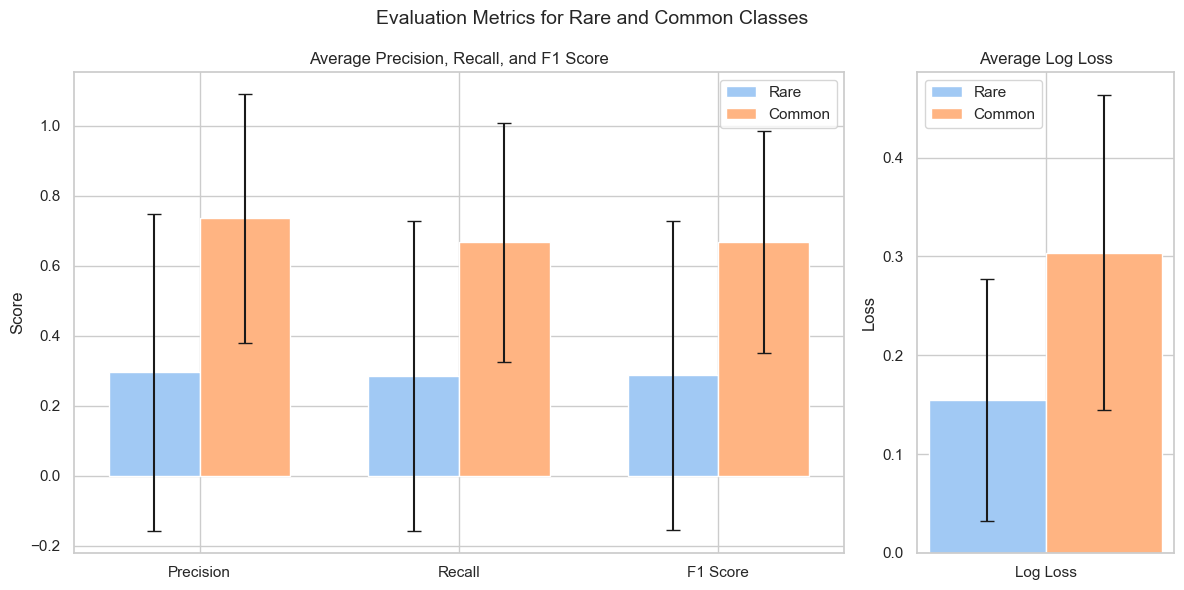

In [47]:
# Get pastel colors from Seaborn
pastel = sns.color_palette("pastel")
rare_color = pastel[0]
common_color = pastel[1]

# Bar values
metrics = ['Precision', 'Recall', 'F1 Score']
x = np.arange(len(metrics)) 

rare_means = [precision_rare, recall_rare, f1_rare]
common_means = [precision_common, recall_common, f1_common]
rare_stds = [precision_rare_std, recall_rare_std, f1_rare_std]
common_stds = [precision_common_std, recall_common_std, f1_common_std]

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [3, 1]})

# Precision, Recall, F1 Score
ax1.bar(x - bar_width/2, rare_means, bar_width, yerr=rare_stds, capsize=5,
        label='Rare', color=rare_color)
ax1.bar(x + bar_width/2, common_means, bar_width, yerr=common_stds, capsize=5,
        label='Common', color=common_color)

ax1.set_xticks(x)
ax1.set_xticklabels(metrics)
ax1.set_ylabel("Score")
ax1.set_title("Average Precision, Recall, and F1 Score")
ax1.legend()

# Log Loss
ax2.bar([0 - bar_width/2], [logloss_rare], yerr=[logloss_rare_std], capsize=5,
        width=bar_width, color=rare_color, label='Rare')
ax2.bar([0 + bar_width/2], [logloss_common], yerr=[logloss_common_std], capsize=5,
        width=bar_width, color=common_color, label='Common')

ax2.set_xticks([0])
ax2.set_xticklabels(["Log Loss"])
ax2.set_ylabel("Loss")
ax2.set_title("Average Log Loss")
ax2.legend()

plt.suptitle("Evaluation Metrics for Rare and Common Classes", fontsize=14)
plt.tight_layout()
plt.savefig("sp1-B.pdf", dpi=300, bbox_inches='tight')

## High vs Low Prevalence Per Disease

In [32]:
# Scaling Down
n_disease = 20
n_test = 20
expected_number_of_diseases = 3
connections = np.random.rand(n_test, n_disease) < sparseness
sensorig = np.full((n_test, n_disease), sensitivity) * connections

n_samples = 10
n_trials = 10

In [33]:
low_prev = 0.05
high_prev = 0.5
base_prev = 0.2

metrics_per_disease = {i: {'precision': [], 'recall': [], 'f1': [], 'sqr_error': []} for i in range(n_disease)}

for i in range(n_disease):
    print(i)

    # All diseases have the same prev
    prev = np.full(n_disease, base_prev)


    for p in ['low', 'high']:
        
        precisions = []
        recalls= []
        f1s = []
        sqr_errors = []

        # Change the prev only for the target disease
        prev[i] = low_prev if p=='low' else high_prev
        prev = expected_number_of_diseases * prev / sum(prev)

        for _ in range (n_trials):
            flag = 1
            while flag:
                actualdiags = np.where(np.random.rand(n_disease) < prev)[0]  # Generate diseases
                ndiags = len(actualdiags)

                testresults = np.any(np.random.rand(n_test, ndiags) < sensorig[:, actualdiags], axis=1)  # Generate test results

                postest = np.where(testresults == 1)[0]
                negtest = np.where(testresults == 0)[0]
                m = len(postest)

                # ndiags kept constant
                if ndiags == 3 and 4 < m < 7 and i in actualdiags:
                    flag = 0  # Exit loop if conditions met
    #                 print(f"trial: {ndiags:3.0f}, {m:3.0f} OK")
        #         else:
        #             print(f"trial: {ndiags:3.0f}, {m:3.0f} try again")

            # Prepare data for Quickscore algorithm
            sens = sensorig[postest, :]
            sensneg = sensorig[negtest, :]
            pfmin = 1 - sens
            pfminneg = np.prod(1 - sensneg, axis=0)

            # Quickscore calculation
            posteriorg, _, _ = fun_quickscoreW2_gmpy2(prev, pfmin, pfminneg)

            actualdiseases = np.zeros_like(prev)
            actualdiseases[actualdiags] = 1
            

            # Compute Metrics
            compute_m = compute_metrics(actualdiseases[i], posteriorg[i])
            precisions.append(compute_m["precision"])
            recalls.append(compute_m["recall"])
            f1s.append(compute_m["f1_score"])
            sqr_errors.append((actualdiseases[i] - posteriorg[i])**2)
        
        metrics_per_disease[i]['precision'].append(np.nanmean(precisions))
        metrics_per_disease[i]['recall'].append(np.nanmean(recalls))
        metrics_per_disease[i]['f1'].append(np.nanmean(f1s))
        metrics_per_disease[i]['sqr_error'].append(np.nanmean(sqr_errors))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


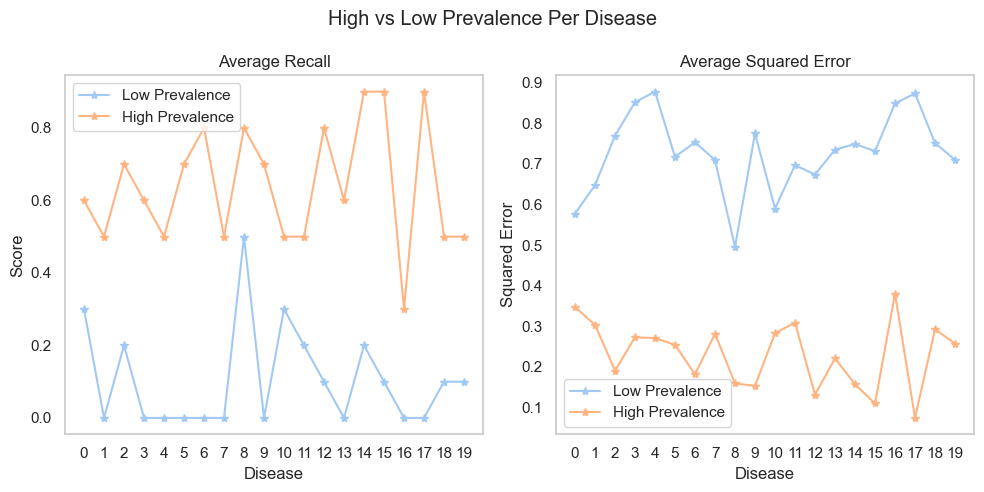

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Remove grid
sns.set_theme(
    style="white",  
    rc={
        "axes.edgecolor": "#cccccc",    
    },palette="pastel"
)

# Prepare labels for low and high prevalence
prevalence_labels = ['Low Prevalence', 'High Prevalence']

plt.suptitle("High vs Low Prevalence Per Disease")


# Recall
axs[0].plot(range(n_disease), [metrics_per_disease[i]['recall'][0] for i in range(n_disease)], marker='*', label='Low Prevalence')
axs[0].plot(range(n_disease), [metrics_per_disease[i]['recall'][1] for i in range(n_disease)], marker='*', label='High Prevalence')
axs[0].set_title('Average Recall')
axs[0].set_xlabel('Disease')
axs[0].set_ylabel('Score')
axs[0].set_xticks(range(n_disease)) 
axs[0].legend()

# Squared Error
axs[1].plot(range(n_disease), [metrics_per_disease[i]['sqr_error'][0] for i in range(n_disease)], marker='*', label='Low Prevalence')
axs[1].plot(range(n_disease), [metrics_per_disease[i]['sqr_error'][1] for i in range(n_disease)], marker='*', label='High Prevalence')
axs[1].set_title('Average Squared Error')
axs[1].set_xlabel('Disease')
axs[1].set_ylabel('Squared Error')
axs[1].set_xticks(range(n_disease)) 
axs[1].legend()

plt.tight_layout()
plt.savefig("sp1-C.pdf", dpi=300, bbox_inches='tight')